Imports

In [1]:
import torch
import torch.nn as nn
from itertools import product
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
import plotly.graph_objects as go
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import random
from stochasticsqp import StochasticSQP
import ipdb


Parameters

In [2]:
# Parameters
hidden_size = 100
num_epochs = 100
lr = 0.00000001
num_classes = 1
threshold = 0.5 
subset_ratio = 0.5 # ratio of the data to be used for the constraint of the model type 4 and 6
ind_sample_size = 64 # size of the sample for males and females
ind_sample_data = False # if True, we sample the male and female, (ind_sample_size), if False, we use all the data
model_types = {5} # model_type = 1 # 1: unconstrained, 2: Sensitive feature removed, 3: regularization term, 4: constrained 
# batch_size = 64
penalty_params = [1e-1]
# , 1e-1, 1e+1, 1e+5, 1e+10, 1e+20

Setting seed

In [3]:
def Seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
Seed(42)

Preprocessing

In [4]:
# Load Data
file_path = "/Users/zahrakhatti/Desktop/Research/codes/classification/1. Classification/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
           'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

df = pd.read_csv(file_path, header=None, skipinitialspace=True, names=columns)
data = df.copy()

# Preprocessing
data['workclass']=data['workclass'].replace('?',np.nan)
data['occupation']=data['occupation'].replace('?',np.nan)
data['native-country']=data['native-country'].replace('?',np.nan)
data.dropna(how='any',inplace=True)
data = data.drop_duplicates()
data = data.drop(['education-num', 'capital-gain', 'capital-loss', 'fnlwgt'], axis=1)

data['income'] = data['income'].map({'>50K': 1, '<=50K': 0})

# Turning categorical to numerical 
label_encoder = preprocessing.LabelEncoder()
data['workclass'] = label_encoder.fit_transform(data['workclass'])
data['education'] = label_encoder.fit_transform(data['education'])
data['marital-status'] = label_encoder.fit_transform(data['marital-status'])
data['occupation'] = label_encoder.fit_transform(data['occupation'])
data['relationship'] = label_encoder.fit_transform(data['relationship'])
data['race'] = label_encoder.fit_transform(data['race'])
data['sex'] = label_encoder.fit_transform(data['sex'])
data['native-country'] = label_encoder.fit_transform(data['native-country'])
data['income'] = label_encoder.fit_transform(data['income'])


# Defining x and y
y = data['income']
x_before = data.drop('income', axis=1)

# Scaling all of the features
scaler = StandardScaler()
x = scaler.fit_transform(x_before)
x = pd.DataFrame(x, columns=x_before.columns)

# Splitting the data to train and test and transforming it to tensor
features = x.values.astype(float)
features_train, features_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

Converting to pytorch


In [5]:
# Convert data to PyTorch tensors
train_tensor_x = torch.tensor(features_train).float()
train_tensor_y = torch.tensor(y_train.values.squeeze()).float() 
test_tensor_x = torch.tensor(features_test).float()
test_tensor_y = torch.tensor(y_test.values.squeeze()).float() 
train_dataset = torch.utils.data.TensorDataset(train_tensor_x, train_tensor_y)
test_dataset = torch.utils.data.TensorDataset(test_tensor_x, test_tensor_y)


''''''
batch_size = len(train_dataset)
''''''

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# The position of the sensitive feature in the dataset
sex_column_index = x.columns.get_loc('sex')

Neural Network model

In [6]:
# Define the neural network model
class Neuralmodel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Neuralmodel, self).__init__()
        self.w1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.w2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):
        h = self.w1(x)
        sigma_h = self.relu(h)
        y_hat = self.w2(sigma_h)
        out = self.sigmoid(y_hat)  
        return out

Defining empty list for storing informations

In [7]:
# For plotting loss and norm_cov based on epochs
losses_dict = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
norm_covariances_dict = {3: [], 4: []}  
norm_independence_dict = {5: [], 6: []} 


results_model = {5: {'penalty': [], 'accuracy': [], 'accuracy_male': [], 'accuracy_female': []}, 
                 6: {'penalty': [], 'accuracy': [], 'accuracy_male': [], 'accuracy_female': []}}

In [8]:
# Covariance term used in model type 3 and 4
'''function: calculate the covariance
input: sample_size, model, s_mean
output: covariance '''
def covariance_fair(features, s_mean, model):
    s = features[:, sex_column_index]
    y_hat = model(features)
    covariance = torch.dot((s - s_mean) , (y_hat - threshold).reshape(-1))/len(s)
    return covariance


'''function: calculate the covariance
input: train_or_test_data, male_sample_size, female_sample_size, ind_sample_data (if True, we sample)
output: male_sample (can be the entire male data), female_sample (can be the entire female data) '''
def independence_prob_sampling(train_or_test_data, male_sample_size, female_sample_size, ind_sample_data):
    s = train_or_test_data.tensors[0][:, sex_column_index]
    male_indices = torch.where(s > 0)[0]
    x_male = train_dataset.tensors[0][male_indices, :]
    male_size = len(male_indices)
    female_indices = torch.where(s < 0)[0]
    x_female = train_dataset.tensors[0][female_indices, :]
    female_size = len(female_indices)

    if ind_sample_data == True:
        male_sample_index = torch.randint(0, male_size, (male_sample_size, ))
        male_sample = x_male[male_sample_index, :]
        female_sample_index = torch.randint(0, female_size, (female_sample_size,))
        female_sample = x_female[female_sample_index, :]
    else:
        male_sample = x_male
        female_sample = x_female
    return male_sample, female_sample

# Independence probability term used in model type 5 and 6
'''function: calculate the independence probability
input: male_sample (can be the entire male data), female_sample (can be the entire female data), model
output: male_ratio, female_ratio '''
def independence_prob_fair(male_sample, female_sample, model):
    Y_hat_male = model(male_sample)
    Y_hat_female = model(female_sample)
    t_male = 1*(Y_hat_male - threshold)
    t_female = 1*(Y_hat_female - threshold)
    epsilon = 1e-1
    male_ratio =  0.5*torch.mean(t_male + torch.sqrt(t_male**2 + epsilon))
    female_ratio =  0.5*torch.mean(t_female + torch.sqrt(t_female**2 + epsilon))
    return male_ratio, female_ratio

Loop through different regularization parameters and model types

In [9]:
# Loop through different regularization parameters
for reg_param in penalty_params:
    # Loop through different model types
    # 1: unconstrained, 2: Sensitive feature removed, 3: regularization term, 4: constrained 
    for model_type in model_types:
        Seed(42)
        input_size = x.shape[1] if model_type != 2 else x.shape[1] - 1

        # model, Loss, and Optimizer
        model = Neuralmodel(input_size, hidden_size, num_classes)
        model = model.to(device)
        criterion = nn.BCELoss() 

        '''function: count_parameters
        input: model
        output: number of parameters in the model'''
        def count_parameters(model):
            return sum(p.numel() for p in model.parameters() if p.requires_grad)
        n_parameters = count_parameters(model)

        if model_type == 4 or model_type == 6:
            n_constrs = 1
        else:
            n_constrs = 0


        ## Initialize optimizer
        optimizer = StochasticSQP(model.parameters(),
                                lr = lr,
                                n_parameters = n_parameters, 
                                n_constrs = n_constrs,
                                merit_param_init = 1, 
                                ratio_param_init = 1)


        ''' Training loop'''
        n_total_steps = len(train_loader)
        s_mean = x['sex'].mean()

        for epoch in range(num_epochs):

            # optimizer.printerHeader()
            for i, (features, labels) in enumerate(train_loader):
                c = torch.tensor([])
                J = torch.zeros(n_constrs,n_parameters)
                if model_type == 2: # Sensitive feature removed
                    features = torch.cat((features[:, :sex_column_index], features[:, sex_column_index+1:]), dim=1)
                # Forward pass
                Y_hat_obj = model(features)
                loss_init = criterion(Y_hat_obj, labels.unsqueeze(1))
                loss = loss_init.clone()

                '''regularization term'''


                '''Different model types'''
                if model_type == 2: # Sensitive feature removed
                    norm_covariance = torch.tensor(0.0)
                    norm_independence = torch.tensor(0.0)
                    female_ratio = torch.tensor(0.0)
                    male_ratio = torch.tensor(0.0)

                if model_type == 3: # Regularization term
                    # Calculate covariance
                    covariance = covariance_fair(features, s_mean, model) 
                    norm_covariance = torch.norm(covariance, p = 2)
                    loss += reg_param * norm_covariance

                if model_type == 4: # Constrained Covariance
                    # Calculate covariance
                    covariance = covariance_fair(features, s_mean, model) 
                    norm_covariance = torch.norm(covariance, p = 2)
                    loss += reg_param * norm_covariance
                    # Compute covariance constraint
                    Seed(42)
                    train_size = len(train_dataset)
                    sample_size = int(subset_ratio * train_size)
                    sample_index = torch.randint(0, train_size, (sample_size, ))
                    const_features = train_dataset.tensors[0][sample_index, :]
                    c = covariance_fair(const_features, s_mean, model) 

                if model_type == 5: # Independence Probability Regularization Term
                    # Calculate equality of probability
                    ind_sample_data = False
                    if ind_sample_data == True:
                        male_sample, female_sample = independence_prob_sampling(train_dataset, ind_sample_size, ind_sample_size, False)
                        male_ratio, female_ratio = independence_prob_fair(male_sample, female_sample, model)
                    else:
                        train_or_test_data = train_dataset
                        s = train_or_test_data.tensors[0][:, sex_column_index]
                        total_male, total_female = independence_prob_sampling(train_or_test_data, len(torch.where(s > 0)[0]), len(torch.where(s > 0)[0]))
                        male_ratio, female_ratio = independence_prob_fair(total_male, total_female, model)
                    independence_res = female_ratio - male_ratio
                    norm_independence = torch.norm(independence_res, p = 2)
                    loss += reg_param * norm_independence
                if model_type == 6: # Constrained Independence Probability
                    # Calculate equality of probability
                    male_ratio, female_ratio = independence_prob_fair(ind_sample_size, ind_sample_size, model)
                    independence_res = female_ratio - male_ratio
                    norm_independence = torch.norm(independence_res, p = 2)
                    loss += reg_param * norm_independence
                    # Compute independent constraint
                    s = train_dataset.tensors[0][:, sex_column_index]
                    male_size = len(torch.where(s > 0)[0])
                    female_size = len(torch.where(s < 0)[0])
                    male_ratio_const, female_ratio_const = independence_prob_fair(int(subset_ratio * male_size), int(subset_ratio * female_size), model)
                    c = (male_ratio_const - female_ratio_const).reshape(-1)

                # Compute gradient of objective
                g = torch.zeros(n_parameters)
                optimizer.zero_grad() 
                loss.backward(retain_graph=True)
                j=0
                for name, param in model.named_parameters(): # Flattens the gradient with respect to parameters in a vector
                    grad_l = len(param.grad.view(-1))
                    g[j:j+grad_l] = param.grad.view(-1)
                    j += grad_l

                # Compute Jacobian
                J = torch.zeros(n_constrs, n_parameters)
                for k in range(n_constrs):
                    optimizer.zero_grad()
                    c.backward(retain_graph=True)
                    grads = torch.Tensor() 
                    for name, param in model.named_parameters():
                        grads = torch.cat((grads, param.grad.view(-1)),0)
                    J[k,:] = grads

                # Update f, g, c, J to optimizer
                optimizer.state['J'] = J
                optimizer.state['c'] = c.data
                optimizer.state['g'] = g
                optimizer.state['f'] = loss.data
                optimizer.step()
                # optimizer.printerIteration(every = 100)


            # Store the losses and norm_covariances to a list for plotting
            losses_dict[model_type].append(loss.item())
            if model_type in {3, 4}:
                norm_covariances_dict[model_type].append(norm_covariance.item())

            if model_type in {5, 6}:
                norm_independence_dict[model_type].append(norm_independence.item())



            # Print loss
            if (epoch % 1 == 0):
                print(f'Epoch [{epoch + 1}/{num_epochs}], Niter: {i}, loss: {loss_init.item():.4f}, Loss+reg: {loss.item():.4f}, '
                      f'Cov_norm: {norm_covariance.item() if model_type in {3, 4} else 0.0:.4f}, '
                      f'female_ratio: {female_ratio.item() if model_type in {5, 6} else 0.0:.4f}, '
                      f'male_ratio: {male_ratio.item():.4f}, indep_norm: {norm_independence.item() if model_type in {5, 6} else 0.0:.4f}')


        '''testing the model'''   
        with torch.no_grad():
            correct = total = correct_male = total_male = correct_female = total_female = 0
            for inputs, labels in test_loader:
                sex = inputs[:, sex_column_index]
                if model_type == 2:
                    # Remove the 'sex' column from the inputs tensor
                    inputs = torch.cat((inputs[:, :sex_column_index], inputs[:, sex_column_index+1:]), dim=1)
                outputs = model(inputs)
                # Applying threshold
                predicted = torch.where(outputs >= threshold, torch.tensor(1), torch.tensor(0))
                correct += (predicted == labels.unsqueeze(1).float()).sum().item()
                total += labels.size(0)
                # Calculate accuracy for male and female separately
                for i in range(len(sex)):
                    if sex[i] > 0 :  
                        total_male += 1
                        if predicted[i] == labels[i]:
                            correct_male += 1
                    elif sex[i] < 0:  
                        total_female += 1
                        if predicted[i] == labels[i]:
                            correct_female += 1
        accuracy = 100 * correct / total
        accuracy_male = 100 * correct_male / total_male 
        accuracy_female = 100 * correct_female / total_female
        if model_type in [5, 6]:
            results_model[model_type]['penalty'].append(reg_param)
            results_model[model_type]['accuracy'].append(accuracy)
            results_model[model_type]['accuracy_male'].append(accuracy_male)
            results_model[model_type]['accuracy_female'].append(accuracy_female)


        model_descriptions = {
            1: "Unconstrained",
            2: "Sensitive Feature Removed",
            3: "Covariance Regularization Term",
            4: "Constrained Covariance",
            5: "Independence Probability Regularization Term",
            6: "Constrained Independence Probability"}
        model_name = model_descriptions[model_type]
        print(f"Model Type {model_type}: {model_name}")  
        print(f'Test Accuracy: {accuracy:.2f}%')
        print(f'Male Accuracy: {accuracy_male:.2f}%')
        print(f'Female Accuracy: {accuracy_female:.2f}%')
        print("--------------------")


Epoch [1/100], Niter: 0, loss: 0.6724, Loss+reg: 0.6748, Cov_norm: 0.0000, female_ratio: 0.1381, male_ratio: 0.1627, indep_norm: 0.0246
Epoch [2/100], Niter: 0, loss: 0.6724, Loss+reg: 0.6748, Cov_norm: 0.0000, female_ratio: 0.1381, male_ratio: 0.1627, indep_norm: 0.0246
Epoch [3/100], Niter: 0, loss: 0.6724, Loss+reg: 0.6748, Cov_norm: 0.0000, female_ratio: 0.1381, male_ratio: 0.1627, indep_norm: 0.0246
Epoch [4/100], Niter: 0, loss: 0.6724, Loss+reg: 0.6748, Cov_norm: 0.0000, female_ratio: 0.1381, male_ratio: 0.1627, indep_norm: 0.0246
Epoch [5/100], Niter: 0, loss: 0.6724, Loss+reg: 0.6748, Cov_norm: 0.0000, female_ratio: 0.1381, male_ratio: 0.1627, indep_norm: 0.0246
Epoch [6/100], Niter: 0, loss: 0.6724, Loss+reg: 0.6748, Cov_norm: 0.0000, female_ratio: 0.1381, male_ratio: 0.1627, indep_norm: 0.0246
Epoch [7/100], Niter: 0, loss: 0.6724, Loss+reg: 0.6748, Cov_norm: 0.0000, female_ratio: 0.1381, male_ratio: 0.1627, indep_norm: 0.0246
Epoch [8/100], Niter: 0, loss: 0.6724, Loss+reg:

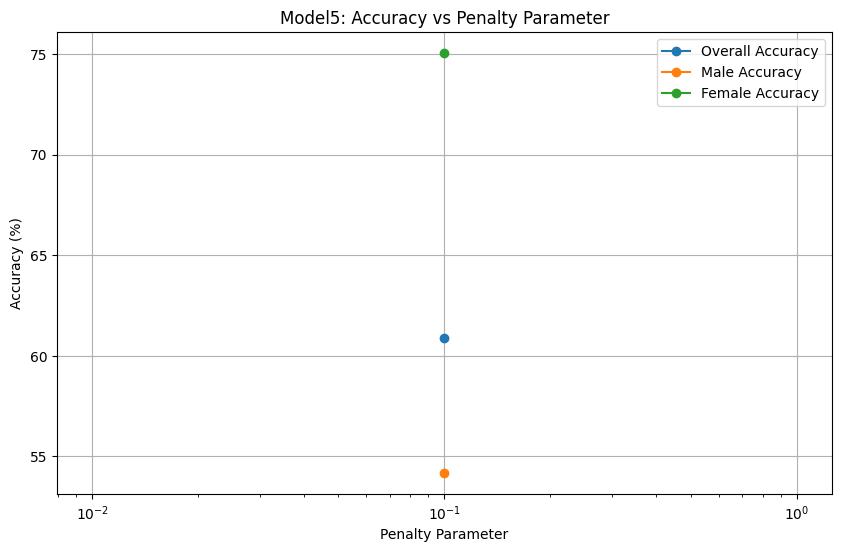

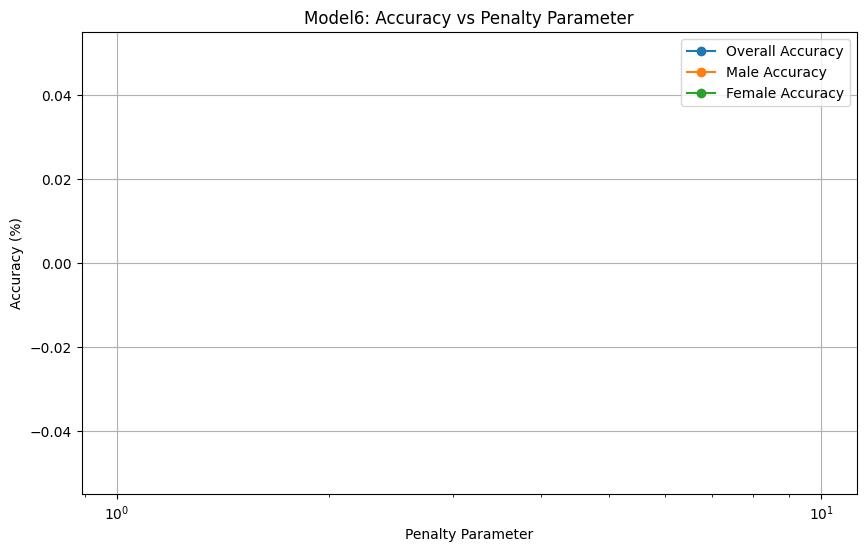

In [10]:
# Plotting accuracy over differnt penalty parameters for model 5 and 6
for model_type in {5, 6}:
    plt.figure(figsize=(10, 6))
    plt.plot(results_model[model_type]['penalty'], results_model[model_type]['accuracy'], label='Overall Accuracy', marker='o')
    plt.plot(results_model[model_type]['penalty'], results_model[model_type]['accuracy_male'], label='Male Accuracy', marker='o')
    plt.plot(results_model[model_type]['penalty'], results_model[model_type]['accuracy_female'], label='Female Accuracy', marker='o')
    plt.xscale('log')
    plt.xlabel('Penalty Parameter')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Model{model_type}: Accuracy vs Penalty Parameter')
    plt.legend()
    plt.grid(True)
    plt.show()

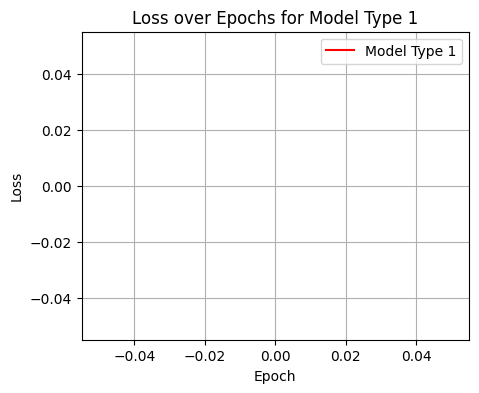

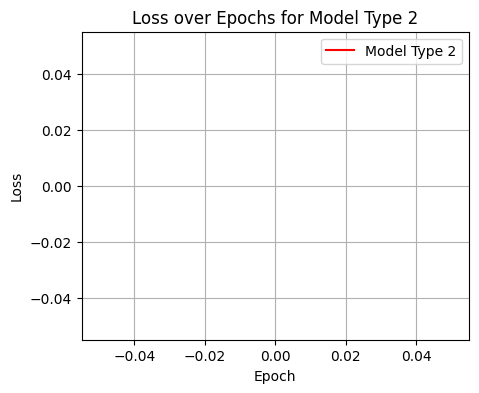

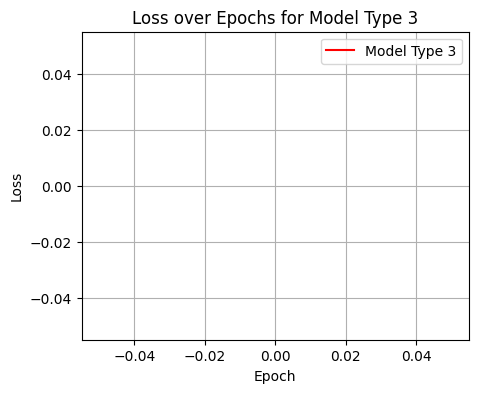

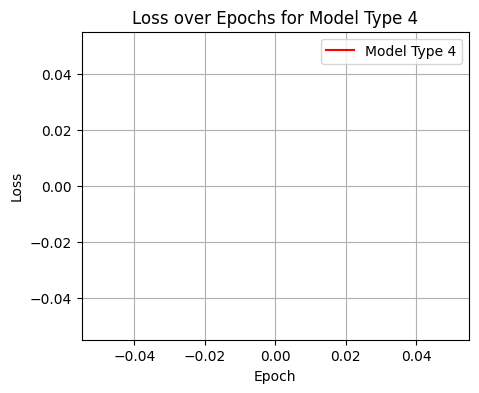

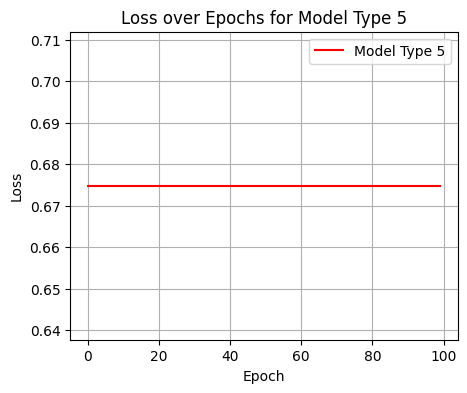

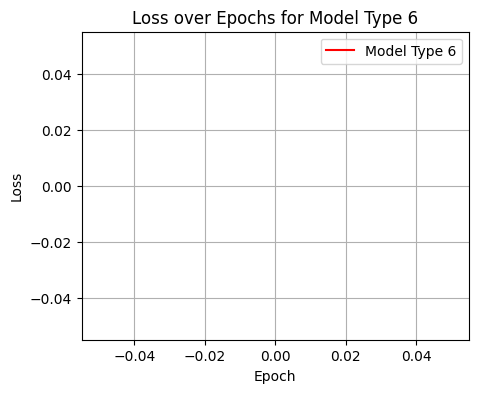

In [11]:
# Plotting the losses for each model type
for model_type, losses in losses_dict.items():
    plt.figure(figsize=(5, 4))  
    plt.plot(losses, label=f'Model Type {model_type}', color='red') 
    plt.title(f'Loss over Epochs for Model Type {model_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

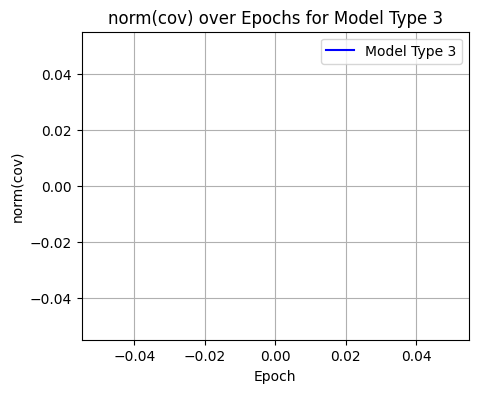

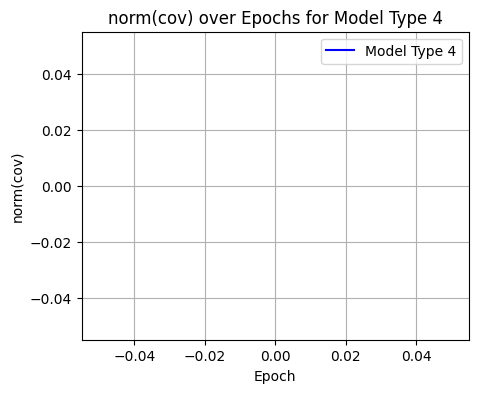

In [12]:
for model_type, norm_covariances in norm_covariances_dict.items():
    plt.figure(figsize=(5, 4))  
    plt.plot(norm_covariances, label=f'Model Type {model_type}', color='blue') 
    plt.title(f'norm(cov) over Epochs for Model Type {model_type}')
    plt.xlabel('Epoch')
    plt.ylabel('norm(cov)')
    plt.legend()
    plt.grid(True)
    plt.show()

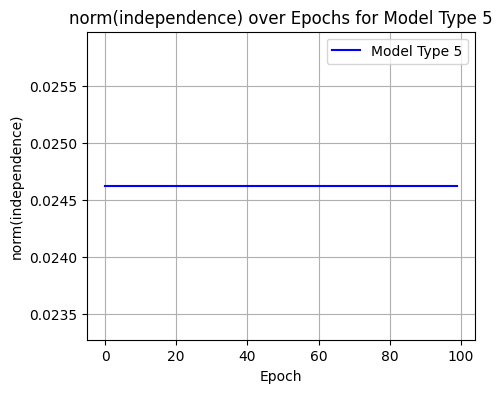

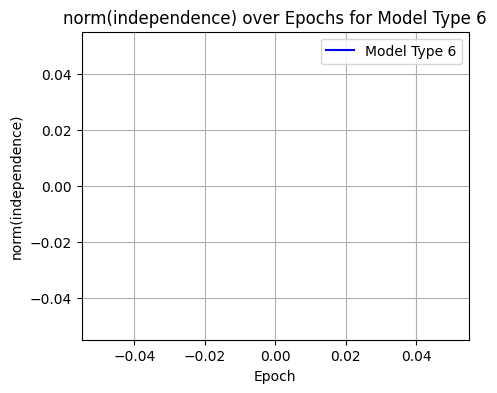

In [13]:
for model_type, norm_independence in norm_independence_dict.items():
    plt.figure(figsize=(5, 4))  
    plt.plot(norm_independence, label=f'Model Type {model_type}', color='blue') 
    plt.title(f'norm(independence) over Epochs for Model Type {model_type}')
    plt.xlabel('Epoch')
    plt.ylabel('norm(independence)')
    plt.legend()
    plt.grid(True)
    plt.show()